In [3]:
import utils
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, t, norm
import numpy as np

alerts_antof, _ = utils.load_data('data/waze.json')

alerts_antof = utils.separate_coords(alerts_antof)

accident = utils.extract_event(alerts_antof, ['ACCIDENT'])
jam = utils.extract_event(alerts_antof, ['JAM'])
hazard = utils.extract_event(alerts_antof, ['HAZARD'])

hourly_accident = utils.hourly_group(accident)
hourly_jam = utils.hourly_group(jam)
hourly_hazard = utils.hourly_group(hazard)

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

linear_model = LinearRegression()

# Join the three DataFrames on the 'hour' index
dat = hourly_accident.join(hourly_jam, lsuffix='_accident', rsuffix='_jam').join(hourly_hazard, rsuffix='_hazard')

dat

day_type,f_accident,s_accident,f_jam,s_jam,f,s
hour,,,,,,
0,9.0,12.0,9,4,33,37
1,7.0,8.0,9,12,33,18
2,5.0,4.0,4,4,32,10
3,3.0,4.0,5,1,13,10
4,2.0,NaN,1,1,40,6
5,6.0,NaN,1,5,15,7
6,7.0,4.0,2,7,17,30
7,14.0,68.0,4,1141,51,133
8,13.0,75.0,9,976,20,148


In [5]:
dat = dat[['s_accident', 's_jam']]

# Fill missing values with 0
dat = dat.fillna(0)

# Create the feature matrix X
X = dat[['s_jam']].values

# Create the target vector y
y = dat['s_accident'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

y_pred

array([23.70347053, 29.30766866, 16.48955592, 30.67890863, 36.34272588])

In [6]:
from sklearn.metrics import root_mean_squared_error, r2_score

print(f'Coeficiente de determinación: {r2_score(y_test, y_pred)}')
print(f'Error cuadrático medio: {root_mean_squared_error(y_test, y_pred)}')


Coeficiente de determinación: 0.7239341847895375
Error cuadrático medio: 5.703647575403033


In [7]:
import statsmodels.formula.api as smf

linear_model = smf.ols(data=dat, formula='s_accident ~ s_jam')
results = linear_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             s_accident   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     96.06
Date:                Mon, 07 Oct 2024   Prob (F-statistic):           1.74e-09
Time:                        18:44:09   Log-Likelihood:                -88.303
No. Observations:                  24   AIC:                             180.6
Df Residuals:                      22   BIC:                             183.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.5777      2.794      3.786      0.0

In [8]:
results.params

Intercept    10.577685
s_jam         0.060233
dtype: float64

In [9]:
1 / results.params['s_jam'] # Proporción congestión / accidentes

np.float64(16.60211893027794)

In [10]:
dat.sum()

day_type
s_accident     702.0
s_jam         7440.0
dtype: float64

In [11]:
dat.sum().loc['s_accident'] / dat.sum().loc['s_jam']

np.float64(0.09435483870967742)

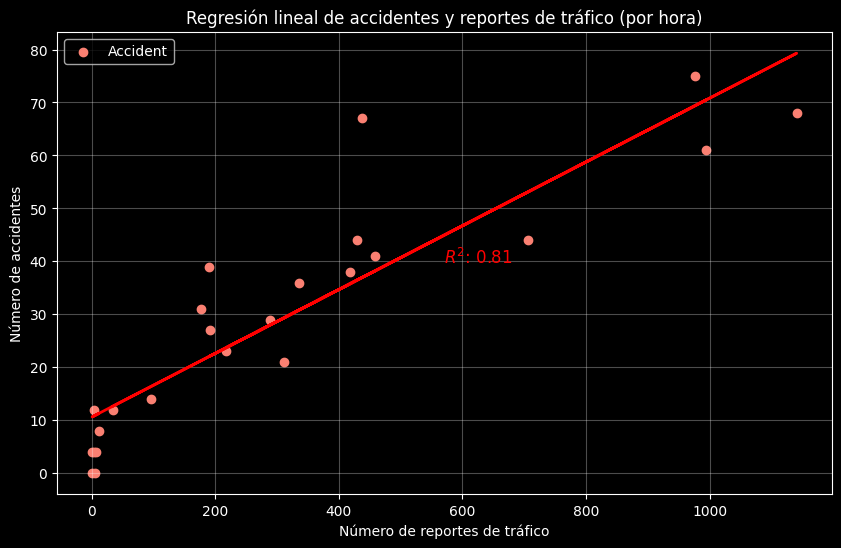

In [12]:
# Grafica la linea de regresión lineal de results y los datos originales

plt.figure(figsize=(10, 6))

# Graficar los datos originales
plt.scatter(dat['s_jam'], dat['s_accident'], color='salmon', label='Accident')

# Graficar la línea de regresión
plt.plot(dat['s_jam'], results.params['Intercept'] + results.params['s_jam'] * dat['s_jam'], color='red', linewidth=2)

plt.title('Regresión lineal de accidentes y reportes de tráfico (por hora)')
plt.text(0.5, 0.5, rf'$R^2$: {results.rsquared:.2f}', transform=plt.gca().transAxes, fontsize=12,  color='red')
plt.xlabel('Número de reportes de tráfico')
plt.ylabel('Número de accidentes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Prueba de hipótesis de correlación de Pearson

La correlación de Pearson es una medida de la relación lineal entre dos variables aleatorias. Es un valor entre -1 y 1, donde:

- 1 indica una correlación positiva perfecta
- -1 indica una correlación negativa perfecta
- 0 indica que no hay correlación

La hipótesis nula de la prueba de correlación de Pearson es que no hay correlación entre las dos variables. La hipótesis alternativa es que hay una correlación entre las dos variables.

La prueba de correlación de Pearson se puede realizar en Python utilizando la función `pearsonr` de la biblioteca `scipy.stats`.

```python
from scipy.stats import pearsonr

# Datos de ejemplo
data1 = [0.1, 0.2, 0.3, 0.4, 0.5]
data2 = [0.5, 0.4, 0.3, 0.2, 0.1]

# Prueba de correlación de Pearson
corr, p_value = pearsonr(data1, data2)

print('Coeficiente de correlación de Pearson:', corr)
print('Valor p:', p_value)
```

En este ejemplo, `data1` y `data2` son dos listas de datos. La función `pearsonr` devuelve el coeficiente de correlación de Pearson y el valor p asociado con la prueba de hipótesis.

### Prueba de hipótesis de correlación con estadístico T

Otra forma de realizar una prueba de correlación es utilizando el estadístico T. La fórmula para el estadístico T es:

$$
t = \frac{r \sqrt{n-2}}{\sqrt{1-r^2}}
$$

Donde $r$ es el coeficiente de correlación de Pearson y $n$ es el número de observaciones.

Para realizar una prueba de hipótesis de correlación con el estadístico T, se compara el valor calculado de $t$ con el valor crítico de la distribución t de Student con $n-2$ grados de libertad.

```python
from scipy.stats import t

# Datos de ejemplo
data1 = [0.1, 0.2, 0.3, 0.4, 0.5]
data2 = [0.5, 0.4, 0.3, 0.2, 0.1]

# Prueba de correlación con estadístico T
corr, p_value = pearsonr(data1, data2)
t_stat = corr * ((len(data1) - 2) ** 0.5) / ((1 - corr ** 2) ** 0.5)
p_value = 2 * (1 - t.cdf(abs(t_stat), len(data1) - 2))

print('Estadístico T:', t_stat)
print('Valor p:', p_value)
```

En este ejemplo, se calcula el estadístico T y el valor p asociado con la prueba de hipótesis de correlación utilizando el estadístico T.

Ambos métodos son válidos para realizar una prueba de correlación de Pearson en Python. La función `pearsonr` es más sencilla de usar, mientras que el cálculo manual del estadístico T proporciona una mayor comprensión de la prueba de hipótesis.

In [13]:
r, p_value = pearsonr(dat.s_jam, dat.s_accident)

r, p_value

(np.float64(0.9020278694758533), np.float64(1.7379251179520305e-09))

In [14]:
n = dat.s_jam.shape[0]

T = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)
T

np.float64(9.801026919770894)

In [15]:
alpha = .05

t_param = -t.ppf(alpha / 2, n - 2)

t_param

np.float64(2.073873067904015)

Dado que T < valor crítico de la distribución t de Student con n - 2 grados de libertad, rechazamos la hipótesis nula y concluimos que hay una correlación entre las dos variables. Además, el valor p es menor que 0.05, lo que confirma la significancia estadística de la correlación.

Validación con transformación de Fisher

$$
Z = \frac{1}{2} \ln\left( \frac{1 + r}{1 - r} \right)
$$

El error estándar asociado a Z se calcula con la siguiente fórmula:

$$
SE_Z = \frac{1}{\sqrt{n - 3}}
$$

In [16]:
Z = 1 / 2 * np.log((1 + r) / (1 - r))
SEz = 1 / np.sqrt(n - 3)
z_param = - norm.ppf(alpha / 2)
ic = [Z - z_param * SEz, Z + z_param * SEz]

ic

[np.float64(1.055297214304987), np.float64(1.9106956255947067)]

Inversa de Fisher Z para obtener el intervalo de confianza en términos de r:

$$
r = \frac{e^{2Z} - 1}{e^{2Z} + 1}
$$

In [17]:
ic_r = [(np.exp(2 * ic[0]) - 1) /  (np.exp(2 * ic[0]) + 1), (np.exp(2 * ic[1]) - 1) /  (np.exp(2 * ic[1]) + 1)]
ic_r

[np.float64(0.783857289427525), np.float64(0.9571438055372955)]

In [18]:
np.power(ic_r, 2)

array([0.61443225, 0.91612426])

### Fin de semana / Feriados

In [19]:

dat = hourly_accident.join(hourly_jam, lsuffix='_accident', rsuffix='_jam').join(hourly_hazard, rsuffix='_hazard')
dat = dat[['f_accident', 'f_jam']]

# Fill missing values with 0
dat = dat.fillna(0)


linear_model = smf.ols(data=dat, formula='f_accident ~ f_jam')
results = linear_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             f_accident   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     3.096
Date:                Mon, 07 Oct 2024   Prob (F-statistic):             0.0924
Time:                        18:44:10   Log-Likelihood:                -71.641
No. Observations:                  24   AIC:                             147.3
Df Residuals:                      22   BIC:                             149.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8910      1.419      6.971      0.0

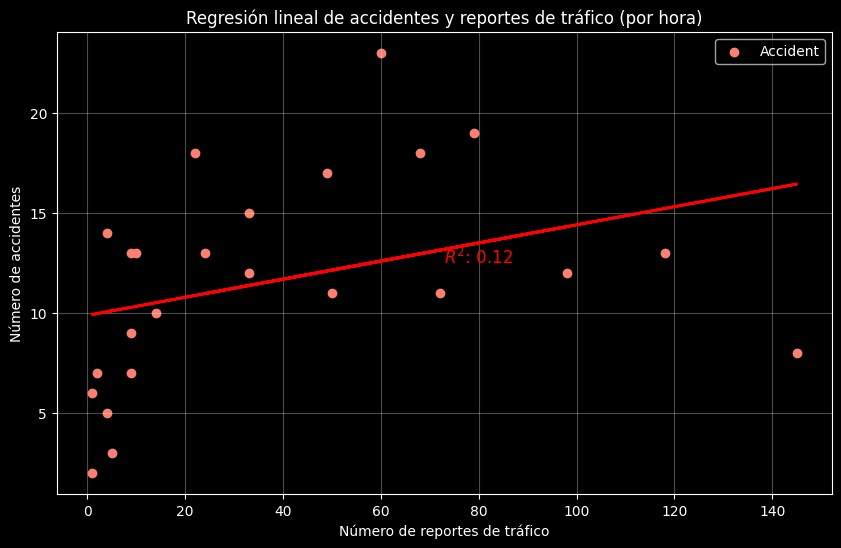

In [20]:
# Grafica la linea de regresión lineal de results y los datos originales

plt.figure(figsize=(10, 6))

# Graficar los datos originales
plt.scatter(dat['f_jam'], dat['f_accident'], color='salmon', label='Accident')

# Graficar la línea de regresión
plt.plot(dat['f_jam'], results.params['Intercept'] + results.params['f_jam'] * dat['f_jam'], color='red', linewidth=2)

plt.title('Regresión lineal de accidentes y reportes de tráfico (por hora)')
plt.text(0.5, 0.5, rf'$R^2$: {results.rsquared:.2f}', transform=plt.gca().transAxes, fontsize=12,  color='red')
plt.xlabel('Número de reportes de tráfico')
plt.ylabel('Número de accidentes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
hourly_accident.sum(), '----',hourly_jam.sum()

(day_type
 f    279.0
 s    702.0
 dtype: float64,
 '----',
 day_type
 f     919
 s    7440
 dtype: int64)

In [22]:
hourly_accident.sum()['f'] / 2

np.float64(139.5)

In [23]:
hourly_accident.sum()['s'] / 5

np.float64(140.4)